# Method 1

torchgeo version: 0.7.1
Files already downloaded and verified
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Số lượng mẫu trong support set: 10
Số lượng mẫu trong query set: 10

--- Đánh giá mô hình trên Query Set ---
Mẫu gốc: baseball_diamond, Dự đoán: bridge
Độ tương đồng: {'bridge': 0.9444114565849304, 'vehicle': 0.8202559351921082}


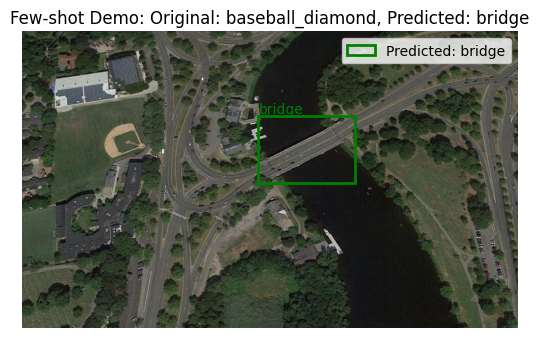

Mẫu gốc: bridge, Dự đoán: bridge
Độ tương đồng: {'bridge': 0.9333825707435608, 'vehicle': 0.9011847376823425}


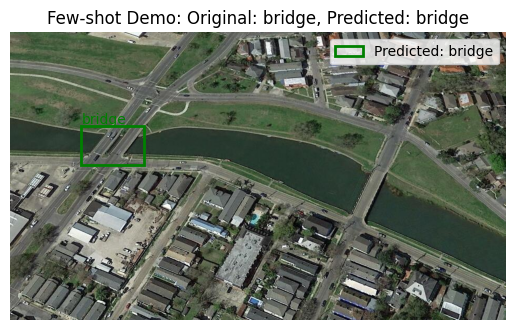

Mẫu gốc: basketball_court, Dự đoán: vehicle
Độ tương đồng: {'bridge': 0.9239278435707092, 'vehicle': 0.9392519593238831}


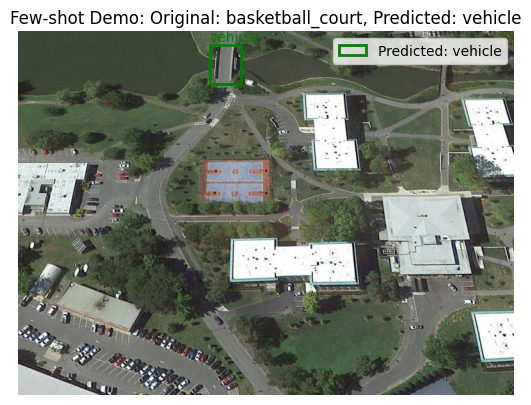

Mẫu gốc: bridge, Dự đoán: bridge
Độ tương đồng: {'bridge': 0.9631240963935852, 'vehicle': 0.8151854276657104}


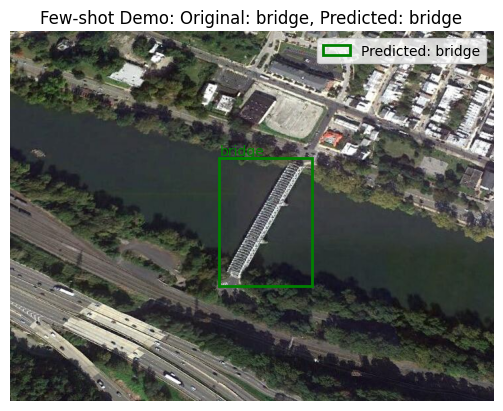

Mẫu gốc: bridge, Dự đoán: bridge
Độ tương đồng: {'bridge': 0.9491778016090393, 'vehicle': 0.8436407446861267}


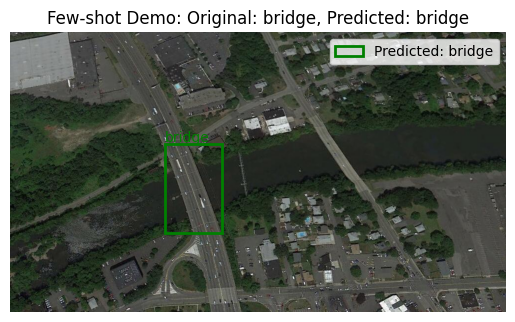

Mẫu gốc: vehicle, Dự đoán: vehicle
Độ tương đồng: {'bridge': 0.7884042263031006, 'vehicle': 0.9077436923980713}


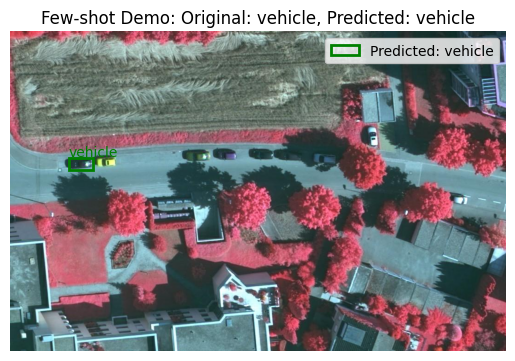

Mẫu gốc: vehicle, Dự đoán: vehicle
Độ tương đồng: {'bridge': 0.7635865211486816, 'vehicle': 0.917386531829834}


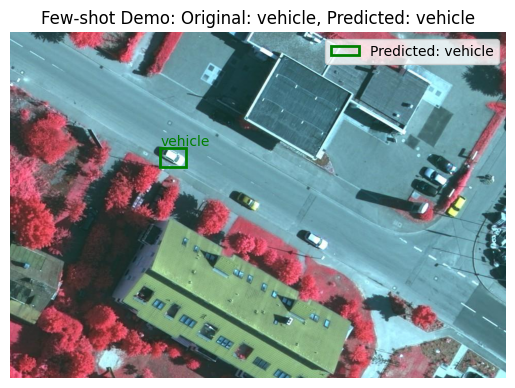

Mẫu gốc: vehicle, Dự đoán: vehicle
Độ tương đồng: {'bridge': 0.9210167527198792, 'vehicle': 0.9275336265563965}


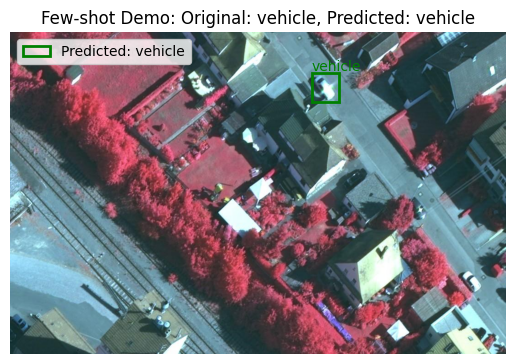

Mẫu gốc: vehicle, Dự đoán: vehicle
Độ tương đồng: {'bridge': 0.8145387172698975, 'vehicle': 0.9444690346717834}


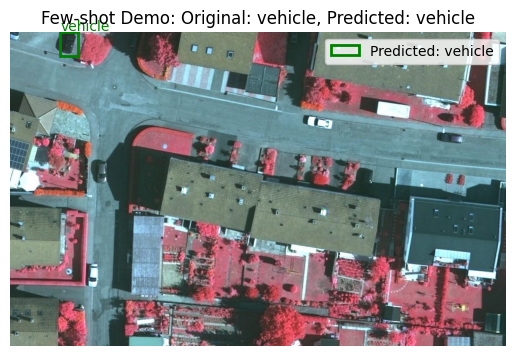

Mẫu gốc: vehicle, Dự đoán: vehicle
Độ tương đồng: {'bridge': 0.8640044331550598, 'vehicle': 0.9197579026222229}


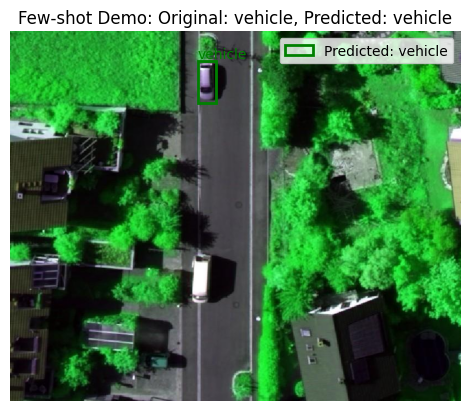


Độ chính xác tổng thể trên 10 mẫu truy vấn: 80.00%


In [1]:
import torch
import torchgeo
import torchvision
from torchgeo.datasets import VHR10
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import defaultdict
import random

# 1. Cài đặt và Tiền xử lý Dataset NWPU VHR-10
# NWPU VHR-10 sẽ được sử dụng để đánh giá mô hình few-shot
print(f"torchgeo version: {torchgeo.__version__}")

def preprocess(sample):
    sample["image"] = sample["image"].float() / 255.0
    return sample

try:
    ds = VHR10(
        root="data/VHR10/",
        split="positive",
        transforms=preprocess,
        download=True,
        checksum=True,
    )
except RuntimeError as e:
    print(f"Lỗi khi tải dataset: {e}")
    print("Vui lòng đảm bảo dataset đã được tải xuống và kiểm tra checksum hợp lệ.")
    exit()

# 2. Định nghĩa các lớp và Thiết lập "Few-shot Episode"
# Chia các lớp thành "cơ sở" và "mới" để mô phỏng bài toán
class_names = [
    "airplane", "ship", "storage_tank", "baseball_diamond", "tennis_court",
    "basketball_court", "ground_track_field", "harbor", "bridge", "vehicle"
]
base_classes = ["airplane", "ship", "storage_tank", "baseball_diamond", "tennis_court", "basketball_court", "ground_track_field", "harbor"]
novel_classes = ["bridge", "vehicle"]

data_by_class = defaultdict(list)
for i in range(len(ds)):
    sample = ds[i]
    labels = sample['label'].unique().tolist()
    if labels:
        for label in labels:
            data_by_class[label].append(sample)

# Thiết lập few-shot episode: N-way, K-shot
# N = số lượng novel classes, K = số lượng mẫu cho mỗi novel class
n_way = len(novel_classes)
k_shot = 5 # Sử dụng 5 mẫu cho mỗi lớp mới trong support set
query_shots = 5 # Số lượng mẫu để truy vấn

# Chuẩn bị Support Set và Query Set
support_set = []
query_set = []
random.seed(42)

for label_name in novel_classes:
    label_id = class_names.index(label_name) + 1
    
    # Lấy ngẫu nhiên K mẫu cho Support Set
    class_samples = data_by_class[label_id]
    random.shuffle(class_samples)
    
    support_set.extend(class_samples[:k_shot])
    
    # Lấy một số mẫu ngẫu nhiên còn lại cho Query Set
    query_set.extend(class_samples[k_shot:k_shot + query_shots])

print(f"Số lượng mẫu trong support set: {len(support_set)}")
print(f"Số lượng mẫu trong query set: {len(query_set)}")

# 3. Kế thừa Tri thức: Sử dụng mô hình đã huấn luyện trước
# FasterRCNN đã được huấn luyện trên COCO, đây là "tri thức" mà chúng ta kế thừa
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
model.eval()

# 4. Học Metric: Tính toán các nguyên mẫu (Prototypes) cho các lớp mới
# Trích xuất đặc trưng từ support set để tạo prototype cho các lớp mới
prototypes = {}
with torch.no_grad():
    for sample in support_set:
        image_tensor = sample['image']
        label_id = sample['label'].unique().tolist()[0]
        label_name = class_names[label_id - 1]
        
        # Cắt vật thể và resize về kích thước chuẩn
        bbox = sample['bbox_xyxy'][0]
        x1, y1, x2, y2 = bbox.int()
        object_roi = torchvision.transforms.functional.crop(image_tensor, y1, x1, y2-y1, x2-x1)
        
        # Trích xuất đặc trưng
        features = model.backbone(object_roi.unsqueeze(0))
        feature_vector = features[list(features.keys())[0]].mean([2, 3])
        
        if label_name not in prototypes:
            prototypes[label_name] = []
        prototypes[label_name].append(feature_vector)

# Tính vector nguyên mẫu cuối cùng bằng cách lấy trung bình
for label, vectors in prototypes.items():
    prototypes[label] = torch.mean(torch.cat(vectors, dim=0), dim=0).unsqueeze(0)

# 5. Đánh giá: Phân loại các vật thể trong Query Set
print("\n--- Đánh giá mô hình trên Query Set ---")
total_correct = 0
total_samples = 0

with torch.no_grad():
    for sample in query_set:
        query_image = sample['image']
        query_bbox = sample['bbox_xyxy']
        original_label_id = sample['label'].unique().tolist()[0]
        original_label_name = class_names[original_label_id - 1]
        
        # Trích xuất đặc trưng từ vật thể truy vấn
        bbox = query_bbox[0]
        x1, y1, x2, y2 = bbox.int()
        object_roi = torchvision.transforms.functional.crop(query_image, y1, x1, y2-y1, x2-x1)
        
        # Trích xuất đặc trưng
        features = model.backbone(object_roi.unsqueeze(0))
        query_feature_vector = features[list(features.keys())[0]].mean([2, 3])
        
        # Tính toán độ tương đồng cosine với tất cả các nguyên mẫu
        similarities = {}
        for label, prototype_vector in prototypes.items():
            cosine_similarity = torch.nn.functional.cosine_similarity(
                query_feature_vector, prototype_vector, dim=1
            )
            similarities[label] = cosine_similarity.item()
        
        predicted_label = max(similarities, key=similarities.get)
        
        if predicted_label == original_label_name:
            total_correct += 1
        total_samples += 1

        print(f"Mẫu gốc: {original_label_name}, Dự đoán: {predicted_label}")
        print(f"Độ tương đồng: {similarities}")
        
        # 6. Hiển thị một ví dụ trực quan
        fig, ax = plt.subplots(1)
        ax.imshow(query_image.permute(1, 2, 0))
        
        # Vẽ bounding box và nhãn dự đoán
        x, y, x2, y2 = query_bbox[0]
        rect = patches.Rectangle((x, y), x2-x, y2-y, linewidth=2, edgecolor='green', facecolor='none', label=f'Predicted: {predicted_label}')
        ax.add_patch(rect)
        plt.text(x, y - 5, f'{predicted_label}', color='green')
    
        plt.title(f'Few-shot Demo: Original: {original_label_name}, Predicted: {predicted_label}')
        plt.legend()
        plt.axis('off')
        plt.show()

print(f"\nĐộ chính xác tổng thể trên {total_samples} mẫu truy vấn: {total_correct/total_samples * 100:.2f}%")

In [2]:
# Lưu mô hình đã được huấn luyện trước
torch.save(model.state_dict(), "few_shot_model.pth")

# Lưu các nguyên mẫu đã học của các lớp mới
torch.save(prototypes, "few_shot_prototypes.pth")

# Lưu danh sách các lớp mới
torch.save(novel_classes, "few_shot_novel_classes.pth")

print("\nĐã lưu mô hình và các nguyên mẫu thành công.")


Đã lưu mô hình và các nguyên mẫu thành công.


Tải mô hình, nguyên mẫu và danh sách lớp thành công.
Files already downloaded and verified
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!

--- Dự đoán trên hình ảnh mới ---
Nhãn thực tế: airplane, Nhãn dự đoán: bridge
Độ tương đồng: {'bridge': 0.9508963227272034, 'vehicle': 0.881253719329834}


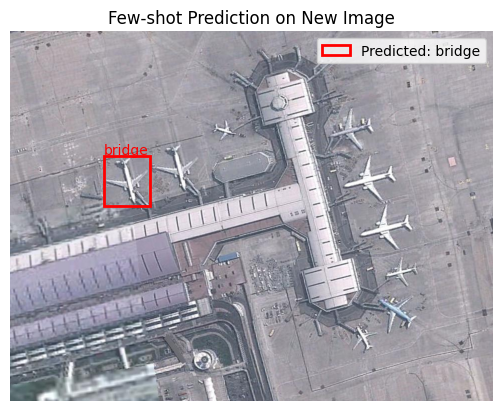

In [3]:
import torch
import torchvision
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# 1. Tải các thành phần đã lưu
try:
    # Tải lại mô hình đã được huấn luyện trước
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
    model.load_state_dict(torch.load("few_shot_model.pth"))
    model.eval()

    # Tải lại các nguyên mẫu (prototypes)
    prototypes = torch.load("few_shot_prototypes.pth")

    # Tải lại danh sách các lớp mới
    novel_classes = torch.load("few_shot_novel_classes.pth")
    class_names = [
        "airplane", "ship", "storage_tank", "baseball_diamond", "tennis_court",
        "basketball_court", "ground_track_field", "harbor", "bridge", "vehicle"
    ]
    print("Tải mô hình, nguyên mẫu và danh sách lớp thành công.")

except FileNotFoundError:
    print("Không tìm thấy các tệp đã lưu. Vui lòng chạy mã demo trước để tạo chúng.")
    exit()

# 2. Chuẩn bị hình ảnh mới để dự đoán
# Giả sử bạn có một hình ảnh mới, ví dụ ds[10] từ dataset NWPU VHR-10
# (Lưu ý: để chạy độc lập, bạn sẽ cần tải NWPU VHR-10 hoặc sử dụng hình ảnh của riêng bạn)

# Đây là một ví dụ, trong thực tế bạn sẽ tải hình ảnh từ một nguồn khác
from torchgeo.datasets import VHR10
ds = VHR10(root="data/VHR10/", split="positive", download=True, checksum=True)

new_image_sample = ds[10]
new_image = new_image_sample['image'].float() / 255.0
new_bbox = new_image_sample['bbox_xyxy'][0]
original_label_id = new_image_sample['label'][0]
original_label_name = class_names[original_label_id - 1]

# 3. Thực hiện dự đoán trên hình ảnh mới
with torch.no_grad():
    # Cắt vật thể từ hình ảnh
    x1, y1, x2, y2 = new_bbox.int()
    object_roi = torchvision.transforms.functional.crop(new_image, y1, x1, y2-y1, x2-x1)
    
    # Trích xuất đặc trưng
    features = model.backbone(object_roi.unsqueeze(0))
    query_feature_vector = features[list(features.keys())[0]].mean([2, 3])
    
    # Tính toán độ tương đồng cosine với các nguyên mẫu đã lưu
    similarities = {}
    for label, prototype_vector in prototypes.items():
        cosine_similarity = torch.nn.functional.cosine_similarity(
            query_feature_vector, prototype_vector, dim=1
        )
        similarities[label] = cosine_similarity.item()
    
    predicted_label = max(similarities, key=similarities.get)
    print("\n--- Dự đoán trên hình ảnh mới ---")
    print(f"Nhãn thực tế: {original_label_name}, Nhãn dự đoán: {predicted_label}")
    print(f"Độ tương đồng: {similarities}")

    # 4. Hiển thị kết quả
    fig, ax = plt.subplots(1)
    ax.imshow(new_image.permute(1, 2, 0))
    x, y, x2, y2 = new_bbox
    rect = patches.Rectangle((x, y), x2-x, y2-y, linewidth=2, edgecolor='red', facecolor='none', label=f'Predicted: {predicted_label}')
    ax.add_patch(rect)
    plt.text(x, y - 5, f'{predicted_label}', color='red')
    plt.title('Few-shot Prediction on New Image')
    plt.legend()
    plt.axis('off')
    plt.show()